# Calculating Clutch: Finding The Most Clutch Player in NHL History

When the lights are at their brightest, hockey's greatest stars shine in ways that mesmerize and blow your mind. Those exciting moments that dominate players make when they show just how much better they are than anyone else on the ice, is something that keeps us all glued to our TVs, waiting to see what happens next. The plays that stick with use more than any other, are always the ones with the highest implications. An overtime goal, a game 7 victory, or even a miraculous comeback. Those moments are seared into hockey history, and leave everyone saying: "Wow they're clutch."

We all know what clutch means. It's great players steppign up and making big plays in big moments. It's such a ubiquitous term for all sports fans, but can we quantify it? Is there a way that we can measure clutch?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Clutch Games

First off, we need to define a "Clutch Game" before we start looking at any stats. There are no games with more pressure than playoffs, so we're only going to be looking at playoff games. While wildcard races in the regular season are exciting, there aren't any trophies handed out for just squeaking into the playoffs.

In the playoffs, we want to find a player's performance in games where mistakes are more costly. Losing in Game 1 is tough, but you still have potentially 6 more games to win the series. So, the first type of "Clutch Game" is going to be any elimination game. Despite, my previous point about Game 1's, an overtime game at any point in a series is a massive momentum swing for the winning team. Therefore, we are also going to be including overtime playoff games, regardless of if it's an elimination game.

So, to reiterate, Clutch Games are:
* Elimination Games
* Overtime Games

We're also going to only look at data from 1986-87 season and forward, since that's when the NHL moved to having each series be Best of 7. [The data was gathered using this incredible python wrapper for the official NHL API by GitHub user coreyjs: nhl-api-py.](https://github.com/coreyjs/nhl-api-py)

In [3]:
games = pd.read_csv('../data/playoffs/game_boxscores_playoffs.csv')
players = pd.read_csv('../data/playoffs/player_boxscores_playoffs.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/playoffs/game_boxscores_playoffs.csv'

In [ ]:
games.head()

,gameId,season,gameType,gameDate,startTimeUTC,venue,venueCity,homeTeamId,homeTeam,homeAbbrev,...,awayAbbrev,homeGoals,awayGoals,homeShotsOnGoal,awayShotsOnGoal,wentToOT,wentToSO,finalPeriodNumber,finalPeriodType,gameState
0,1986030111,19861987,3,1987-04-08,1987-04-08T23:30:00Z,Hartford Civic Center,Hartford,34,Hartford,HFD,...,QUE,3,2,41,25,True,False,4,OT,OFF
1,1986030112,19861987,3,1987-04-09,1987-04-09T23:30:00Z,Hartford Civic Center,Hartford,34,Hartford,HFD,...,QUE,5,4,29,24,False,False,3,REG,OFF
2,1986030113,19861987,3,1987-04-11,1987-04-11T23:30:00Z,Le Colisée,Quebec City,32,Quebec,QUE,...,HFD,5,1,37,30,False,False,3,REG,OFF
3,1986030114,19861987,3,1987-04-12,1987-04-12T23:30:00Z,Le Colisée,Quebec City,32,Quebec,QUE,...,HFD,4,1,37,29,False,False,3,REG,OFF
4,1986030115,19861987,3,1987-04-14,1987-04-14T23:30:00Z,Hartford Civic Center,Hartford,34,Hartford,HFD,...,QUE,5,7,43,24,False,False,3,REG,OFF


In [ ]:
players.head()

,gameId,team,teamAbbrev,homeOrAway,playerId,playerName,position,positionGroup,sweaterNumber,timeOnIce,...,shots,hits,blockedShots,plusMinus,pim,powerPlayGoals,faceoffWinningPctg,shifts,giveaways,takeaways
0,1986030111,Quebec,QUE,away,8448655,Lane Lambert,R,F,7,NaN,...,3,0,0,0,2,0,0.0,0,0,0
1,1986030111,Quebec,QUE,away,8447310,Michel Goulet,L,F,16,NaN,...,3,0,0,0,4,0,0.0,0,0,0
2,1986030111,Quebec,QUE,away,8449498,Basil Mcrae,L,F,17,NaN,...,2,0,0,0,17,0,0.0,0,0,0
3,1986030111,Quebec,QUE,away,8447985,Mike Hough,L,F,18,NaN,...,0,0,0,1,11,0,0.0,0,0,0
4,1986030111,Quebec,QUE,away,8446178,Alain Cote,L,F,19,NaN,...,2,0,0,-2,0,0,0.0,0,0,0


In [ ]:
# Extract series information from gameId
# gameId format: YYYY03RRSG where RR=round, S=series in that round, G=game number
games['gameIdStr'] = games['gameId'].astype(str)
games['round'] = games['gameIdStr'].str[6:8].astype(int)
games['seriesId'] = games['gameIdStr'].str[6:9]  # Round + series
games['gameNumber'] = games['gameIdStr'].str[9:10].astype(int)

# Create a unique series identifier
games['uniqueSeriesId'] = games['season'].astype(str) + '_' + games['seriesId']

# Sort by season, round, series, and game number to process in order
games = games.sort_values(['season', 'round', 'seriesId', 'gameNumber']).reset_index(drop=True)

# For each series, identify the two teams and assign consistent ordering
series_teams = {}
for series_id in games['uniqueSeriesId'].unique():
    series_games = games[games['uniqueSeriesId'] == series_id]
    team1 = series_games.iloc[0]['awayTeamId']
    team2 = series_games.iloc[0]['homeTeamId']
    # Store teams in consistent order (lower ID first)
    if team1 < team2:
        series_teams[series_id] = (team1, team2)
    else:
        series_teams[series_id] = (team2, team1)

# Initialize new columns
games['team1Wins'] = 0
games['team2Wins'] = 0
games['seriesScore'] = ''
games['eliminationGame'] = False

# Calculate series scores and elimination games
for idx, row in games.iterrows():
    series_id = row['uniqueSeriesId']
    team1, team2 = series_teams[series_id]
    
    if idx == 0 or row['uniqueSeriesId'] != games.iloc[idx-1]['uniqueSeriesId']:
        # First game of a series
        games.at[idx, 'team1Wins'] = 0
        games.at[idx, 'team2Wins'] = 0
        games.at[idx, 'seriesScore'] = '0-0'
        games.at[idx, 'eliminationGame'] = False
    else:
        prev_row = games.iloc[idx - 1]
        
        # Get previous game's series score
        team1_wins = prev_row['team1Wins']
        team2_wins = prev_row['team2Wins']
        
        # Update based on who won previous game
        if prev_row['homeGoals'] > prev_row['awayGoals']:
            # Home team won
            winner_id = prev_row['homeTeamId']
        else:
            # Away team won
            winner_id = prev_row['awayTeamId']
        
        if winner_id == team1:
            team1_wins += 1
        else:
            team2_wins += 1
        
        games.at[idx, 'team1Wins'] = team1_wins
        games.at[idx, 'team2Wins'] = team2_wins
        
        # Format series score as away-home for this specific game
        if row['awayTeamId'] == team1:
            games.at[idx, 'seriesScore'] = f'{team1_wins}-{team2_wins}'
        else:
            games.at[idx, 'seriesScore'] = f'{team2_wins}-{team1_wins}'
        
        # Elimination game: either team has 3 wins
        games.at[idx, 'eliminationGame'] = (team1_wins == 3 or team2_wins == 3)

# Drop temporary columns
games = games.drop(['gameIdStr', 'uniqueSeriesId', 'team1Wins', 'team2Wins'], axis=1)

print(f"Added columns: gameNumber, seriesScore, eliminationGame")
print(f"Total games: {len(games)}")
print(f"Elimination games: {games['eliminationGame'].sum()}")


Added columns: gameNumber, seriesScore, eliminationGame
Total games: 3298
Elimination games: 907


In [ ]:
# filter only for the "clutch" games

clutch_mask = (games["eliminationGame"] == True) | (games["wentToOT"] == True)
clutch_game_ids = games.loc[clutch_mask, "gameId"]
games["clutchGames"] = games["gameId"].isin(clutch_game_ids)

clutch_games = games[clutch_mask]
num_clutch_games = len(clutch_games)
ot_clutch_games = len(clutch_games[clutch_games["wentToOT"] == True])
elim_clutch_games = len(clutch_games[clutch_games["eliminationGame"] == True])

print(f"Number of clutch games: {num_clutch_games}")
print(f"Number of OT clutch games: {ot_clutch_games}")
print(f"Number of elimination clutch games: {elim_clutch_games}")


Number of clutch games: 1422
Number of OT clutch games: 717
Number of elimination clutch games: 907


From all playoff games since the 1986-87 season, there have been 1422 Clutch Games. Of those 1422, 907 of them have been elimination games, and 717 have been overtime games or elimination games. In this chart the overtime games are a little inflated, since they include elimination games that went to OT. However, in our calculations we are not counting them twice. It's just good to see them to get an understanding of the breakdown.

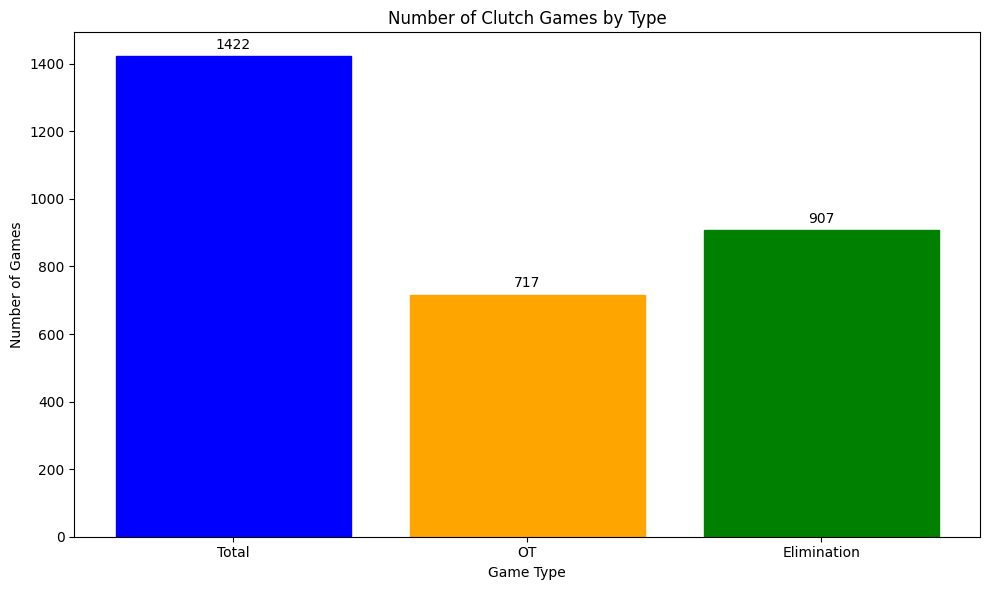

In [ ]:
x = range(3)

plt.figure(figsize=(10, 6))
bars = plt.bar(x, [num_clutch_games, ot_clutch_games, elim_clutch_games])

bars[0].set_color('blue')
bars[1].set_color('orange')
bars[2].set_color('green')

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')
plt.title("Number of Clutch Games by Type")
plt.xlabel("Game Type")
plt.ylabel("Number of Games")
plt.xticks(x, ["Total", "OT", "Elimination"])
plt.tight_layout()
plt.show()


In [ ]:
players["clutchGames"] = players["gameId"].isin(clutch_game_ids)

# Add clutchWin column: True if player is in a clutch game AND their team won
# Merge with games to get home/away goals
players_with_game_info = players.merge(
    games[['gameId', 'homeGoals', 'awayGoals']], 
    on='gameId', 
    how='left'
)

# Determine if player's team won
players_with_game_info['teamWon'] = (
    ((players_with_game_info['homeOrAway'] == 'home') & 
     (players_with_game_info['homeGoals'] > players_with_game_info['awayGoals'])) |
    ((players_with_game_info['homeOrAway'] == 'away') & 
     (players_with_game_info['awayGoals'] > players_with_game_info['homeGoals']))
)

# Create clutchWin column
players['clutchWin'] = players_with_game_info['clutchGames'] & players_with_game_info['teamWon']

print(f"Total player-game records: {len(players)}")
print(f"Player-games in clutch games: {players['clutchGames'].sum()}")
print(f"Player-games with clutch wins: {players['clutchWin'].sum()}")


Total player-game records: 118728
Player-games in clutch games: 51192
Player-games with clutch wins: 25596


Alright, now that we have our Clutch Games clearly defined, who played in the most Clutch Games! Initially, I was very surprised to see Corey Perry here, but then I realized it's actually pretty unsurprising. Corey Perry was a Stanley Cup champ in 2007, the leader of many incredible Anaheim Ducks teams in the 2010's, made three straight finals from 2020-2022, and recently made back to back finals appearances again. An amazing resume that's going to drive up those Clutch Games numbers.

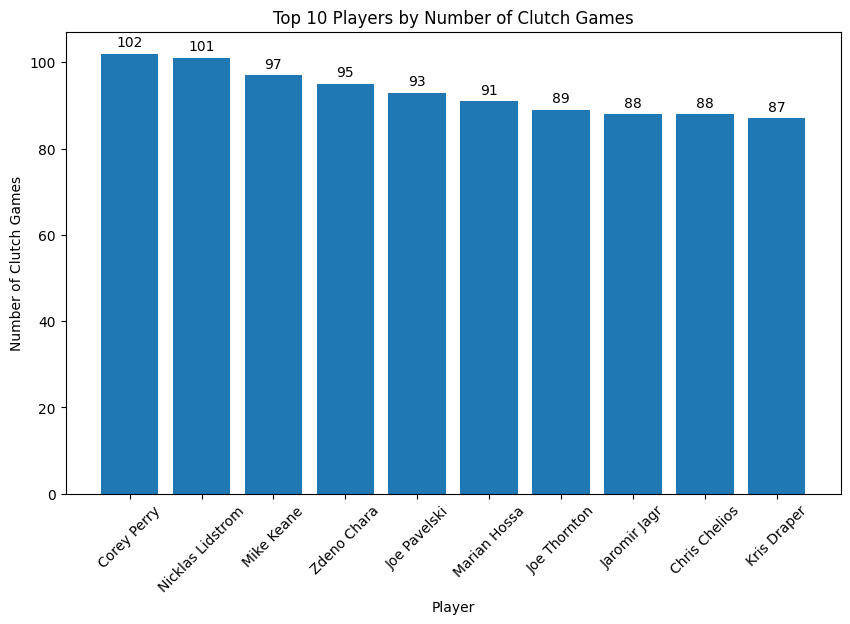

In [ ]:
clutch_players = players[players["clutchGames"] == True]

clutch_games = clutch_players.groupby("playerName")["clutchGames"].sum()

top_10_clutch_players = clutch_games.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_clutch_players.index, top_10_clutch_players.values)
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')
plt.title("Top 10 Players by Number of Clutch Games")
plt.xlabel("Player")
plt.xticks(rotation=45)
plt.ylabel("Number of Clutch Games")
plt.show()


In fact, if we look at the distribution of all players and the number of Clutch Games they played in, then we can see the distribution is very heavily skewed right. This makes sense as winning Clutch Games is going to give you more opportunities to be in additional Clutch Games. 

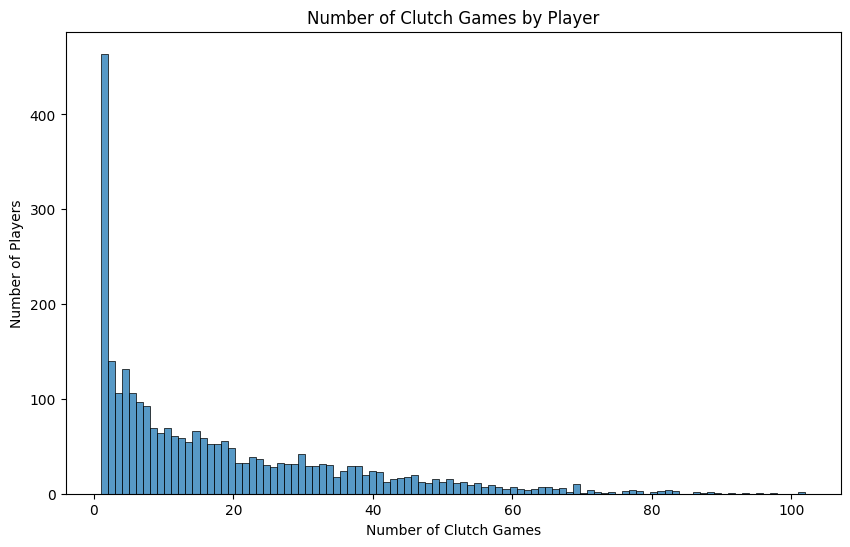

In [ ]:
plt.figure(figsize=(10, 6))

sns.histplot(clutch_players["playerName"].value_counts(), bins=100)
plt.title("Number of Clutch Games by Player")
plt.xlabel("Number of Clutch Games")
plt.ylabel("Number of Players")
plt.show()



Just being in a Clutch Game is not clutch though. We want to know how well players perform in those games! If we take a look at the points distribution, we can see that it's also very heavily skewed right. This is exciting as it means that the Clutch Leaders are going to be truly something special, and absolute outliers from the rest of the pack. In essense, not everyone is clutch, and we'll be able to find the truly special players.

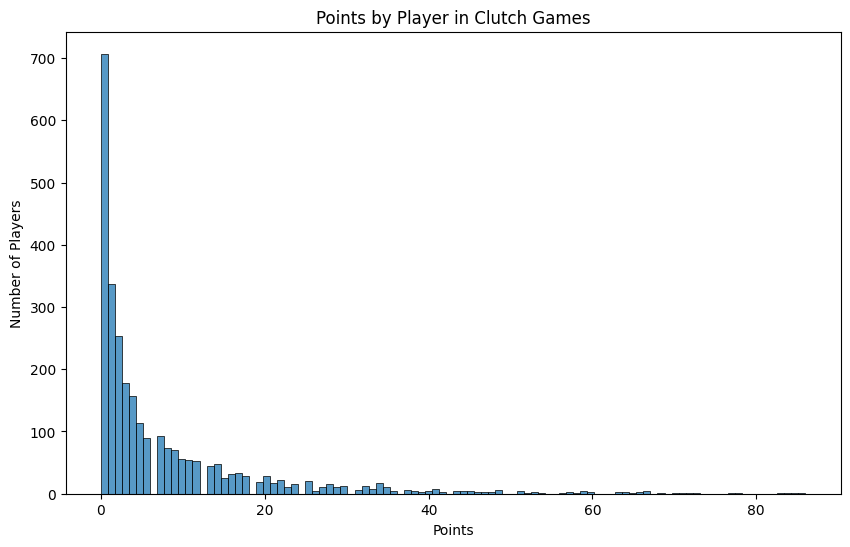

In [ ]:
clutch_points = clutch_players.groupby("playerName")["points"].sum()

plt.figure(figsize=(10, 6))
sns.histplot(clutch_points, bins=100)
plt.title("Points by Player in Clutch Games")
plt.xlabel("Points")
plt.ylabel("Number of Players")
plt.show()

When looking at just the top 10 in points in Clutch Games, right away we see a difference from the game appearances. This is closer to what we're looking for. We want players that bury their opponents in these games. When the pressure is high, these players dominate. 

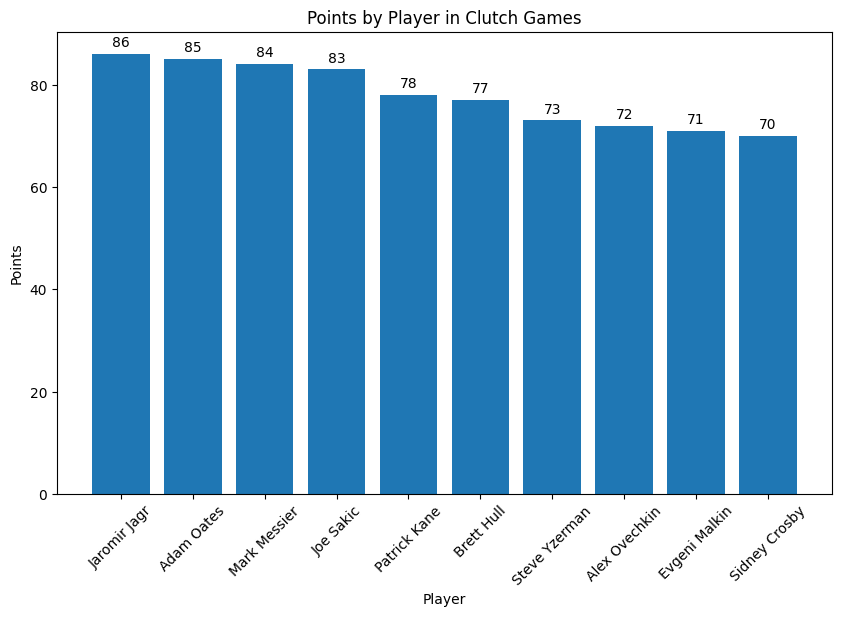

In [ ]:
clutch_points = clutch_players.groupby(
    "playerName"
    )["points"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = plt.bar(clutch_points.index, clutch_points.values)
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')
plt.title("Points by Player in Clutch Games")
plt.xlabel("Player")
plt.xticks(rotation=45)
plt.ylabel("Points")
plt.show()


The top 10 list is filled with legends from different eras like Jagr, Messier, Kane, and Crosby. Points are important, but I also want to know the breakdown of these. Which players are scoring goals without hassle, and who's setting up their teammates beautifully with great playmaking.

Here we see some big differences in playstyle. Crosby and Malkin are both in the top 10 and only one point apart from each other, but Crosby has many more assists from setting up Malkin to score goals. Also, players like Ovechkin and Pavelski have many more goals than assits as compared to other players.

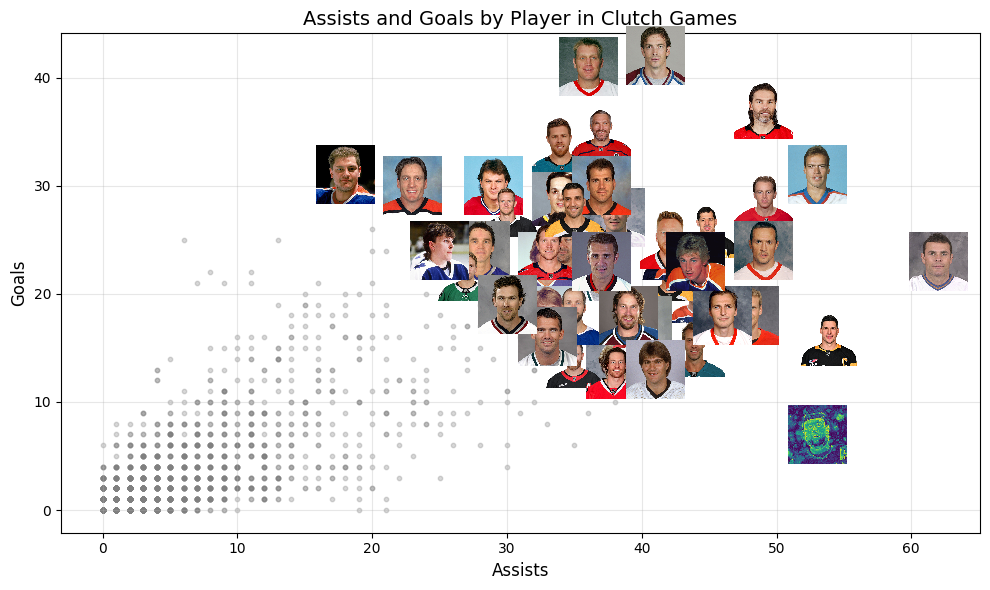

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import requests
from io import BytesIO

player_ids = clutch_players.groupby("playerName")["playerId"].first()

def get_headshot(player_id, ax, x, y, zoom=0.15):
    """Download player headshot from NHL assets CDN and place it on the plot"""
    urls = [
        f"https://assets.nhle.com/mugs/nhl/latest/{player_id}.png",
        f"https://cms.nhl.bamgrid.com/images/headshots/current/168x168/{player_id}.jpg",
        f"https://cms.nhl.bamgrid.com/images/headshots/current/168x168/{player_id}@2x.jpg"
    ]
    
    for url in urls:
        try:
            response = requests.get(url, timeout=5)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content))
                imagebox = OffsetImage(img, zoom=zoom)
                ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0)
                ax.add_artist(ab)
                return True
        except:
            continue
    return False

fig, ax = plt.subplots(figsize=(10, 6))

all_x = []
all_y = []
headshot_x = []
headshot_y = []
failed_headshot_x = []
failed_headshot_y = []

# Get top 20 players by total points in clutch games
player_points = clutch_players.groupby("playerName")["points"].sum()
n_players = 50
top_n_players = player_points.sort_values(ascending=False).head(n_players).index

clutch_assists = clutch_players.groupby("playerName")["assists"].sum()
clutch_goals = clutch_players.groupby("playerName")["goals"].sum()

for player_name in clutch_assists.index:
    if player_name in clutch_goals.index:
        x = clutch_assists[player_name]
        y = clutch_goals[player_name]
        
        if player_name in top_n_players and player_name in player_ids.index:
            player_id = player_ids[player_name]
            success = get_headshot(player_id, ax, x, y, zoom=0.125)
            if not success:
                failed_headshot_x.append(x)
                failed_headshot_y.append(y)
            else:
                headshot_x.append(x)
                headshot_y.append(y)
        else:
            all_x.append(x)
            all_y.append(y)

# Plot scatter points
if all_x:
    ax.scatter(all_x, all_y, alpha=0.3, s=10, c='gray')
if failed_headshot_x:
    ax.scatter(failed_headshot_x, failed_headshot_y, alpha=0.5, s=50, c='blue')

# KEY FIX: Manually set axis limits to include ALL points (including headshots)
all_x_values = all_x + failed_headshot_x + headshot_x
all_y_values = all_y + failed_headshot_y + headshot_y

if all_x_values and all_y_values:
    x_margin = (max(all_x_values) - min(all_x_values)) * 0.05
    y_margin = (max(all_y_values) - min(all_y_values)) * 0.05
    ax.set_xlim(min(all_x_values) - x_margin, max(all_x_values) + x_margin)
    ax.set_ylim(min(all_y_values) - y_margin, max(all_y_values) + y_margin)

ax.set_title("Assists and Goals by Player in Clutch Games", fontsize=14)
ax.set_xlabel("Assists", fontsize=12)
ax.set_ylabel("Goals", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Scoring empty stats is meaningless though. We want to make sure we are rewarding wins as well. Taking a look at Clutch Wins, we see a more similar list to the appearance list, but in a slightly different order. Good! We are going to be expecting to see many familiar faces across these lists. The leaders keep changing, and so does the order. That's why it's so hard to give a definitive answer as to who is the most clutch. To do that, we are going to bring all this information together to create one unified Clutch Score.

Funny aside about Pronger who sits at rank 10, I once gave a presentation to my company, which is an Ad Agency, about a reinforcement learning model I made that learned to play NHL Hitz 2003. The cover of that game features Pronger. Little did I know, the agency I work for designed the cover!

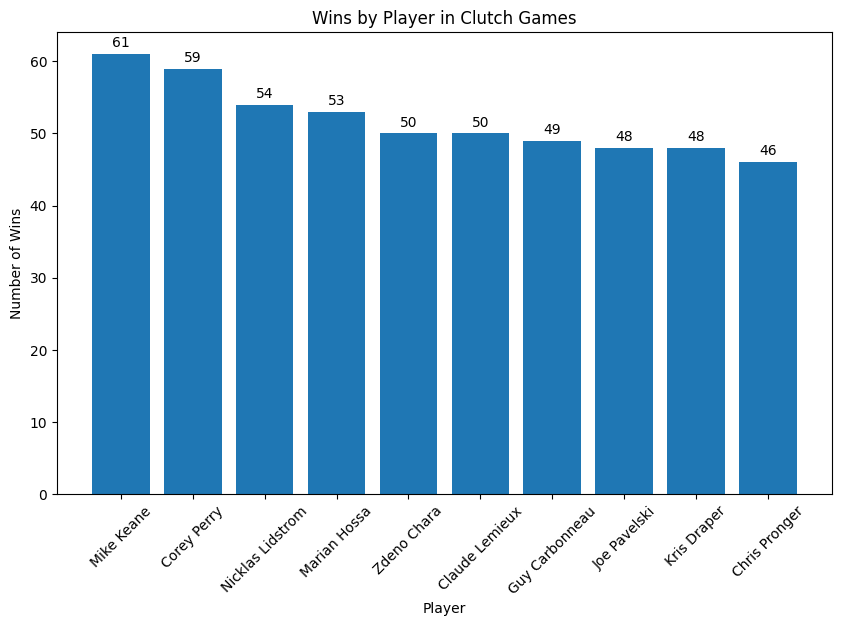

In [ ]:
clutch_wins = clutch_players.groupby("playerName")["clutchWin"].sum()
clutch_wins_top_10 = clutch_wins.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = plt.bar(clutch_wins_top_10.index, clutch_wins_top_10.values)
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')
plt.title("Wins by Player in Clutch Games")
plt.xlabel("Player")
plt.xticks(rotation=45)
plt.ylabel("Number of Wins")
plt.show()



## Clutch Score

So how are we going to use this information to find the most clutch player? Well, we have to know what we want to reward, and what we want to discourage. 

Goals should be more important than assists. In the end, the team with the most goals wins. However, we don't want to discourage great playmaking. So, making assists worth 90% of a goal. This should be a high enough weight where they are still important, but should reduce the impact of plays that may not have directly influenced a goal. Wins should also be extrememly significant. So, let's make the points in losses only half as important as points in wins. Finally, a clutch player dominates. Once we get the weighted point totals, we will multiply it by the win percentage to get our final clutch score.

### Clutch Score Formula

The clutch score is calculated as follows:

$$
\text{Clutch Score} = \text{Weighted Clutch Points} \times \text{Win Percentage}
$$

Where:

$$
\text{Weighted Clutch Points} = P_{\text{wins}} + 0.5 \times P_{\text{losses}}
$$

$$
P_{\text{wins}} = (G_{\text{wins}} \times 1.0) + (A_{\text{wins}} \times 0.9)
$$

$$
P_{\text{losses}} = (G_{\text{losses}} \times 1.0) + (A_{\text{losses}} \times 0.9)
$$

$$
\text{Win Percentage} = \frac{\text{Clutch Wins}}{\text{Clutch Games}}
$$

**Legend:**
- $G_{\text{wins}}$ = Goals scored in clutch wins
- $A_{\text{wins}}$ = Assists in clutch wins
- $G_{\text{losses}}$ = Goals scored in clutch losses
- $A_{\text{losses}}$ = Assists in clutch losses our final clutch score.

The last part is not really intuitive initially, but let me explain why multiplying by the win percentage is extremely important. Essentially, our score is "Clutch Win Adjusted Production." It would have been much easier to understand if we had "Clutch Production Per Game" (CPPG), but that brings up many issues. For one, not every player has played in many clutch games. The CPPG leader is [Lonny Bohonos](https://www.hockey-reference.com/players/b/bohonlo01.html) who played in 2 clutch games where he scored 3 total points and won both. In second place, we have Mario Lemieux who played in a ridiculous 37 clutch games and scored an absurd 65 points in them. But, Mario only won 24 of those clutch games which is heavily penalized by the loss penalty. 

"Clutch Production Per Win" has similar issues, so I've found that multiplying by the win percentage strikes a good balance between rewarding wins and penalizing losses, while minimizing the impact of small sample sizes.

In [ ]:
goal_weight = 1.0
assist_weight = 0.9
loss_multiplier = 0.5

In [ ]:
# Calculate points in wins vs losses separately (CAREER TOTALS)
clutch_wins_players = clutch_players[clutch_players["clutchWin"] == True]
clutch_losses_players = clutch_players[clutch_players["clutchWin"] == False]

points_in_wins = clutch_wins_players.groupby("playerName")["points"].sum()
points_in_losses = clutch_losses_players.groupby("playerName")["points"].sum()

goals_in_wins = clutch_wins_players.groupby("playerName")["goals"].sum()
goals_in_losses = clutch_losses_players.groupby("playerName")["goals"].sum()

assists_in_wins = clutch_wins_players.groupby("playerName")["assists"].sum()
assists_in_losses = clutch_losses_players.groupby("playerName")["assists"].sum()

# Create career clutch dataframe
clutch_df = clutch_players.groupby("playerName").agg({
    "clutchWin": "sum",
    "goals": "sum",
    "assists": "sum",
    "clutchGames": "sum",
    "points": "sum"
}).reset_index()

# Map the win/loss stats to the dataframe
clutch_df["points_in_wins"] = clutch_df["playerName"].map(points_in_wins).fillna(0)
clutch_df["points_in_losses"] = clutch_df["playerName"].map(points_in_losses).fillna(0)

clutch_df["goals_in_wins"] = clutch_df["playerName"].map(goals_in_wins).fillna(0)
clutch_df["goals_in_losses"] = clutch_df["playerName"].map(goals_in_losses).fillna(0)

clutch_df["assists_in_wins"] = clutch_df["playerName"].map(assists_in_wins).fillna(0)
clutch_df["assists_in_losses"] = clutch_df["playerName"].map(assists_in_losses).fillna(0)

weighted_goals_wins = (clutch_df["goals_in_wins"] * goal_weight)
weighted_goals_losses = (clutch_df["goals_in_losses"] * goal_weight)
weighted_assists_wins = (clutch_df["assists_in_wins"] * assist_weight)
weighted_assists_losses = (clutch_df["assists_in_losses"] * assist_weight)
weighted_points_wins = weighted_goals_wins + weighted_assists_wins
weighted_points_losses = weighted_goals_losses + weighted_assists_losses
weighted_clutch_points = weighted_points_wins + (loss_multiplier * weighted_points_losses)

# Calculate clutch win percentage (safe division to avoid divide by zero)
clutch_win_pct = np.divide(
    clutch_df["clutchWin"], 
    clutch_df["clutchGames"], 
    out=np.zeros_like(clutch_df["clutchWin"], dtype=float), 
    where=clutch_df["clutchGames"] != 0
)

# Add to dataframe
clutch_df["clutchWinPct"] = clutch_win_pct
clutch_df["clutch_score"] = weighted_clutch_points * clutch_win_pct

clutch_df = clutch_df.replace([np.inf, -np.inf], np.nan).dropna()

clutch_df.sort_values(by="clutch_score", ascending=False)[[
    "playerName", 
    "clutchWin", 
    "clutchGames", 
    "points", 
    "goals", 
    "assists", 
    "clutchWinPct", 
    "clutch_score"
    ]].head(10)


,playerName,clutchWin,clutchGames,points,goals,assists,clutchWinPct,clutch_score
2033,Patrick Kane,44,68,78,29,49,0.647059,41.314706
1645,Mark Messier,37,63,84,31,53,0.587302,39.114286
1272,Joe Sakic,44,82,83,42,41,0.536585,36.541463
26,Adam Oates,43,77,85,23,62,0.558442,35.768182
1342,Jonathan Toews,43,65,66,24,42,0.661538,35.193846
340,Brett Hull,45,83,77,41,36,0.542169,35.105422
1619,Mario Lemieux,24,37,65,27,38,0.648649,33.924324
2735,Wayne Gretzky,32,52,67,23,44,0.615385,33.723077
1118,Jaromir Jagr,45,88,86,37,49,0.511364,33.417614
1618,Marian Hossa,53,91,67,25,42,0.582418,32.265934


Unsurprisingly, every single player in the top 10 deserves to be there. There's some absolute legends of the game in this list. And standing above the rest, Patrick Kane has set himself apart as the most clutch player of all time. An unbelievable 78 points in clutch games that are boosted by a sky high 64.7% Clutch Win Percentage, made him absolute must watch TV in his prime.

## Showtime

Patrick Kane is nicknamed showtime for good reason. His highlight reel is never ending with jaw dropping play after jaw dropping play. 

[Perhaps there's none as memeorable to me as this one though, and no it's not the 2010 Finals goal.](https://www.youtube.com/watch?v=yfQghQ6_1Qg)

He was an absolute force on the Chicago Blackhawks dynasty from 2010 - 2015, but which season was his most clutch?

In [ ]:
# Calculate clutch score by season (SINGLE-SEASON TOTALS)
# First, add season information to players dataframe
players_with_season = players.merge(
    games[['gameId', 'season']], 
    on='gameId', 
    how='left'
)

# Filter for clutch games only
clutch_players_with_season = players_with_season[players_with_season["clutchGames"] == True]

# Separate wins and losses
clutch_wins_season = clutch_players_with_season[clutch_players_with_season["clutchWin"] == True]
clutch_losses_season = clutch_players_with_season[clutch_players_with_season["clutchWin"] == False]

# Calculate goals and assists in wins and losses by player AND season
goals_in_wins_season = clutch_wins_season.groupby(["playerName", "season"])["goals"].sum()
assists_in_wins_season = clutch_wins_season.groupby(["playerName", "season"])["assists"].sum()
goals_in_losses_season = clutch_losses_season.groupby(["playerName", "season"])["goals"].sum()
assists_in_losses_season = clutch_losses_season.groupby(["playerName", "season"])["assists"].sum()

# Create season-based clutch dataframe
clutch_df_season = clutch_players_with_season.groupby(["playerName", "season"]).agg({
    "clutchWin": "sum",
    "goals": "sum",
    "assists": "sum",
    "clutchGames": "sum",
    "points": "sum"
}).reset_index()

# Map goals and assists for wins and losses
clutch_df_season["goals_in_wins"] = clutch_df_season.set_index(
    ["playerName", "season"]
    ).index.map(goals_in_wins_season).fillna(0).values
clutch_df_season["assists_in_wins"] = clutch_df_season.set_index(
    ["playerName", "season"]
    ).index.map(assists_in_wins_season).fillna(0).values
clutch_df_season["goals_in_losses"] = clutch_df_season.set_index(
    ["playerName", "season"]
    ).index.map(goals_in_losses_season).fillna(0).values
clutch_df_season["assists_in_losses"] = clutch_df_season.set_index(
    ["playerName", "season"]
    ).index.map(assists_in_losses_season).fillna(0).values

# Calculate clutch score using the function
weighted_goals_wins = (clutch_df_season["goals_in_wins"] * goal_weight)
weighted_goals_losses = (clutch_df_season["goals_in_losses"] * goal_weight)
weighted_assists_wins = (clutch_df_season["assists_in_wins"] * assist_weight)
weighted_assists_losses = (clutch_df_season["assists_in_losses"] * assist_weight)
weighted_points_wins = weighted_goals_wins + weighted_assists_wins
weighted_points_losses = weighted_goals_losses + weighted_assists_losses
weighted_clutch_points = weighted_points_wins + (loss_multiplier * weighted_points_losses)

# Calculate clutch win percentage (safe division to avoid divide by zero)
clutch_win_pct = np.divide(
    clutch_df_season["clutchWin"], 
    clutch_df_season["clutchGames"], 
    out=np.zeros_like(clutch_df_season["clutchWin"], dtype=float), 
    where=clutch_df_season["clutchGames"] != 0
)

# Add to dataframe
clutch_df_season["clutchWinPct"] = clutch_win_pct
clutch_df_season["clutch_score"] = weighted_clutch_points * clutch_win_pct

clutch_df_season.loc[
    clutch_df_season["playerName"] == "Patrick Kane"
    ].sort_values(
        by="clutch_score", ascending=False)[
            [
                "playerName", 
                "season", 
                "clutchGames", 
                "points", 
                "goals", 
                "assists", 
                "clutchWinPct", 
                "clutch_score"
            ]].head(10)

,playerName,season,clutchGames,points,goals,assists,clutchWinPct,clutch_score
8868,Patrick Kane,20142015,11,16,5,11,0.818182,11.822727
8867,Patrick Kane,20132014,9,16,6,10,0.666667,9.066667
8863,Patrick Kane,20092010,8,12,5,7,0.750000,7.762500
8866,Patrick Kane,20122013,11,10,4,6,0.818182,6.586364
8862,Patrick Kane,20082009,7,6,5,1,0.714286,3.857143
8864,Patrick Kane,20102011,4,4,1,3,0.750000,2.775000
8869,Patrick Kane,20152016,4,3,1,2,0.500000,1.400000
8865,Patrick Kane,20112012,6,4,0,4,0.333333,0.750000
8871,Patrick Kane,20192020,3,4,1,3,0.333333,0.616667
8872,Patrick Kane,20222023,3,1,0,1,0.333333,0.150000


The 2014-15 Blackhawks were an older group that had already won two Stanley Cups in 2010 and 2013. With long playoff runs in that span as well, the team was largely injured and beaten from wear and tear. Their defense was so depleted, that Duncan Keith (the Conn Smythe Winnner this year) averaged 25:35 minutes of ice time a game! This team was a step slower than the flashy teams from 2010 and 2013, but they were also the best team that dynasty had. With years of experience and a winning culture, this team was unstoppable. Simply put, this team knew how to win and would not be denied.

In [ ]:
patrick_kane_clutch_games = clutch_players[clutch_players["playerName"] == "Patrick Kane"]
patrick_kane_clutch_games_201415 = patrick_kane_clutch_games[
    (patrick_kane_clutch_games["gameId"] >= 2014000000) & 
    (patrick_kane_clutch_games["gameId"] < 2015000000)
]
patrick_kane_clutch_games_201415.sort_values(
    by=["points", "gameId"], ascending=[False, False]
    )[["gameId", "playerName", "points", "goals", "assists"]]

,gameId,playerName,points,goals,assists
86014,2014030327,Patrick Kane,3,0,3
86248,2014030416,Patrick Kane,2,1,1
85996,2014030326,Patrick Kane,2,1,1
85330,2014030234,Patrick Kane,2,1,1
84376,2014030166,Patrick Kane,2,1,1
84178,2014030161,Patrick Kane,2,0,2
85924,2014030324,Patrick Kane,1,1,0
84322,2014030165,Patrick Kane,1,0,1
84304,2014030164,Patrick Kane,1,0,1
85942,2014030325,Patrick Kane,0,0,0


Showtime had every team gamplanning against him, and drew an insane amount of attention to him every game. He had the most points in a Game 7 stomp of the Anaheim Ducks, which is one of the best series I've ever watched, but I think the game that perfectly captures how clutch Kane is Game 6 of the Stanley Cup finals where he had one goal and one assist.

In the second period Kane is streaking down the right side of the boards drawing 2 defenders towards him, and catching all 4 Lightning players puck watching since they know he's the most dangerous player in the game.
# ![defense staring at Kane](/Users/mattanikiej/nhl-stats/clutch/defense_staring.png)

The defenseman covering center is so focused on Kane that he doesn't notice Keith barreling down towards him, and he is caught flat footed when Kane sets up Keith perfectly. This allows Keith to blow by him with ease and follow his shot for an easy rebound goal.
# ![defense caught flat footed](/Users/mattanikiej/nhl-stats/clutch/flat_footed.png)

Then with 5 minutes left, the Blackhawks get an odd man rush. The defenseman on the Lightning chooses to play the pass to make Brad Richards take a shot instead of Kane. However, he doesn't fully commit since he doesn't want to give up a free shot on the goalie, which allows an easy one timer for Kane who takes full advantage of the opportunity.
# ![kane wide open for a one timer](/Users/mattanikiej/nhl-stats/clutch/kane_goal.png)

The 2-0 lead with 5 minutes left was too much for the Lightning to overcome. Patrick Kane had a point on every goal scored in Game 6. This was the Blackhawks chance to finally win on home ice after previously winning in Philadelphia and Boston. In moments like these, clutch players make magic happen. Was there ever a nickname more deserved than Showtime?

# Thanks For Reading!

This one was a lot of fun! I expected that Gretzky was going to be number 1 by a mile like he is with every other stat, but I was surprised that Mark Messier actually had a higher clutch score than him. To be honest though, this makes that both of them are lower than I expected. I only took data form 1986-87+, which is already well into the Oilers dynasty. I wanted to keep it to Best of Seven series, and more modern seasons, since the economy of the game is very different in previous years compared to now. Espescially since the salary cap was introduced. Overall though, I was very excited to see that Patrick Kane was number 1 as he's my all time favorite player, so that was a nice surprise.

Let me know if you enjoyed, and what your thoughts were on this!
